In [3]:
%load_ext autoreload
%autoreload 1
%matplotlib notebook

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
import sys, os
import numpy as np
import matplotlib.pyplot as plt

sys.path.append('..')
%aimport mre_pinn

##  Poisson forward FEM

Strong form:

$$
\begin{align}
    \mu \nabla^2 \mathbf{u} + \rho \omega^2 \mathbf{u} = 0
\end{align}
$$

Variational form:

$$
\begin{align}
    \int_\Omega \mu \nabla \mathbf{u} \nabla \mathbf{v} dx - \int_\Omega \rho \omega^2 \mathbf{u} \mathbf{v} dx = 0
\end{align}
$$

In [5]:
import ufl
import dolfinx
from mpi4py import MPI
from petsc4py.PETSc import ScalarType
ScalarType

numpy.complex128

In [6]:
# define the mesh

n_x = 100
n_y = 100

mesh = dolfinx.mesh.create_rectangle(
    comm=MPI.COMM_WORLD,
    points=[[-1, -1], [1, 1]], n=[n_x, n_y],
    cell_type=dolfinx.mesh.CellType.triangle
)
mesh.geometry.x.shape

(10201, 3)

In [7]:
# define the function space

V = dolfinx.fem.FunctionSpace(mesh, ('Lagrange', 1))
V

FunctionSpace(Mesh(VectorElement(FiniteElement('Lagrange', triangle, 1), dim=2), 0), FiniteElement('Lagrange', triangle, 1))

In [8]:
def on_boundary(x):
    return np.isclose(np.linalg.norm(x, np.inf, axis=0), 1)

# identify dofs on the boundary
boundary_dofs = dolfinx.fem.locate_dofs_geometrical(V, on_boundary)

In [9]:
# define boundary condition

def u_bc_func(x):
    return 0

#bc = dolfinx.fem.Function(V)
#bc.interpolate(u_bc_func)

bc = dolfinx.fem.dirichletbc(value=ScalarType(0), dofs=boundary_dofs, V=V)

In [17]:
# define variational problem using UFL

u = ufl.TrialFunction(V)
v = ufl.TestFunction(V)
x = ufl.SpatialCoordinate(mesh)
f = 4 + 0 * x[0]

# setup variational problem
a = ufl.inner(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = ufl.inner(f, v) * ufl.dx

# compute FEM solution
problem = dolfinx.fem.petsc.LinearProblem(a, L, bcs=[bc])
uhat = problem.solve()
print('Done')

Done


In [18]:
# evaluate functions on mesh

x = x = np.stack(np.meshgrid(
    np.linspace(-1, 1, n_x + 1),
    np.linspace(-1, 1, n_y + 1),
    np.zeros(1),
), axis=-1).reshape(-1, 3)

# identify cells that contain the coordinates
tree = dolfinx.geometry.BoundingBoxTree(mesh, mesh.geometry.dim)
cells = dolfinx.geometry.compute_collisions(tree, x)
cells = dolfinx.geometry.compute_colliding_cells(mesh, cells, x)
cells = [cells.links(i)[0] for i in range(x.shape[0])]

uhat_x = uhat.eval(x, cells)
uhat_x = uhat_x.reshape(n_x + 1, n_y + 1)
uhat_x.shape

(101, 101)

<IPython.core.display.Javascript object>


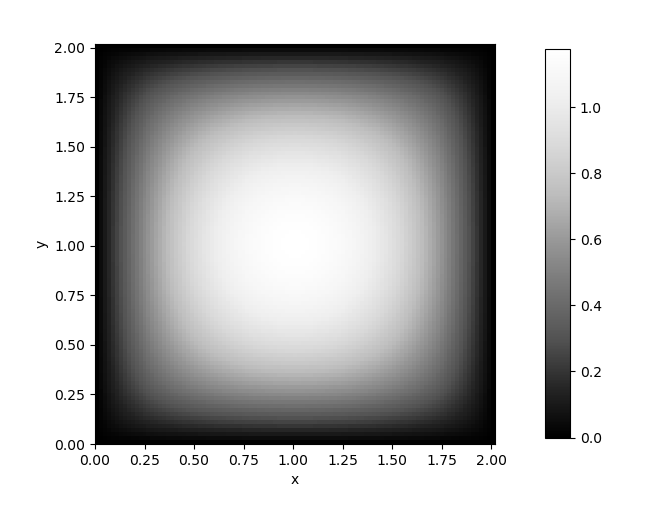

interactive(children=(SelectionSlider(description='part', options=(('real', 0), ('imag', 1)), value=0), Select…

In [19]:
# visualize the displacement

import xarray as xr

dims = ['x', 'y']
coords = {
    'x': np.linspace(-1, 1, n_x + 1),
    'y': np.linspace(-1, 1, n_y + 1)
}
xr_uhat_x = xr.DataArray(uhat_x, dims=dims, coords=coords)


mre_pinn.visual.XArrayViewer(xr_uhat_x, ax_width=4, cmap='Greys_r')